In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     PL = pmax - pmin
#     offset = 0.5*(pmax + pmin)
#     PL/2 * (sin(pi * (param - offset)/PL) + 1) + pmin
# end
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

limit_func (generic function with 1 method)

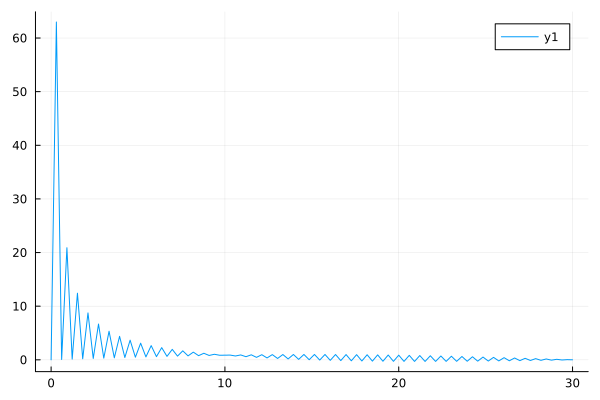

In [111]:
T = 30.0
N_freqs = 100
ωs = [n*pi/T for n in range(1,N_freqs)]
times = LinRange(0,30,100)
plot(times,sum([sin.(ω.*times) for ω in ωs]))

In [125]:
function pulse(p, t)
    sig = 0
    for (i, A) in enumerate(p)
        sig += A * sin(ωs[i]*t)
    end
    sig
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [126]:
function augmented_H_int!(du, u, p, t)
    H = KinPot12 + Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    
    a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
    ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
    # a = reshape(u[1:NHilbert],1,:)
    # ψT = u[NHilbert+1:2*NHilbert]

    du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
    du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
    # du[1:NHilbert] = im .* a * hamil
    # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
    
    du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t) #+ 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
    # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
end

augmented_H_int! (generic function with 1 method)

In [127]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT, counter]
# counter = 0
ps = []
ls = []

function H_int!(du, u, p, t)
    H = KinPot12 + Potential3
    V = pulse(p, t) .* chargecoupling
    du[:] = - im * (H + V) * u
end

E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
# ψ1s
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        buffer[6] += 1
        if buffer[6] % 100 == 0
            writedlm("tmp_ps.txt",ps)
            writedlm("tmp_ls.txt",ls)
        end
        # buffer[3] = get_Pot3(0.995pi)#p[8])
        # Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        # buffer[1] = real(Es[2] - Es[1])
        # buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        
        # T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(H_int!, ψ1s[:,1:2], (0.0, 30.0), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

function loss_func(buffer)
    UT = abs2.(ψ1s'*buffer[5])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss = loss_func(buffer)
    push!(ps,copy(last_p))
    push!(ls,copy(loss))
    return loss
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

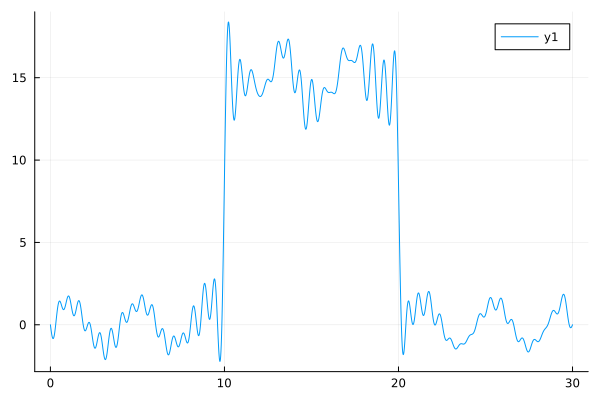

In [193]:
times = LinRange(0,30.0,2000)

# amps = (rand(N_freqs) .- 0.5)
amps = (- cos.(20 .* ωs) ./ ωs + cos.(10 .* ωs) ./ ωs) - 100*tmp_deriv - 1*tmp_deriv2
plot(times, [pulse(amps,t) for t in times])

In [194]:
p = amps

initial_p = copy(p)
buffer = [nothing,nothing,nothing,nothing,zeros(ComplexF64,NHilbert,2),0]
last_p = similar(initial_p);

In [195]:
f(initial_p,last_p,buffer)

0.9238476832640116

In [185]:
storage = similar(last_p)
tmp_deriv2 = g!(storage,p,last_p,buffer)

100-element Vector{Float64}:
  0.003636203130013726
 -0.025596341369959596
 -0.01658701774762666
  0.018937341284157076
  0.008772002257556708
 -0.003351808528496967
  0.0008313708455342422
 -0.024091922327009522
 -0.005164367849931856
  0.014045601465814482
  ⋮
 -0.023270606310162947
 -0.0863447198716858
 -0.02072888016861256
  0.08971555856689105
  0.06165870211522222
  0.0011711702008272834
 -0.0453567949565309
 -0.03754610910996184
 -0.014652008007109025

In [129]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS(),
               Optim.Options(f_tol=5e-5,g_tol=1e-8,show_every=10))

 * Status: success

 * Candidate solution
    Final objective value:     2.581933e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.15e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.94e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.13e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.39e-05 ≤ 5.0e-05
    |g(x)|                 = 6.30e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   275896  (vs limit Inf)
    Iterations:    110
    f(x) calls:    259
    ∇f(x) calls:   259


In [131]:
writedlm("tmp_ps.txt",ps)
writedlm("tmp_ls.txt",ls)
# ps = readdlm("tmp_ps.txt")
# ls = readdlm("tmp_ls.txt");

In [203]:
p_new = copy(Optim.minimizer(res));

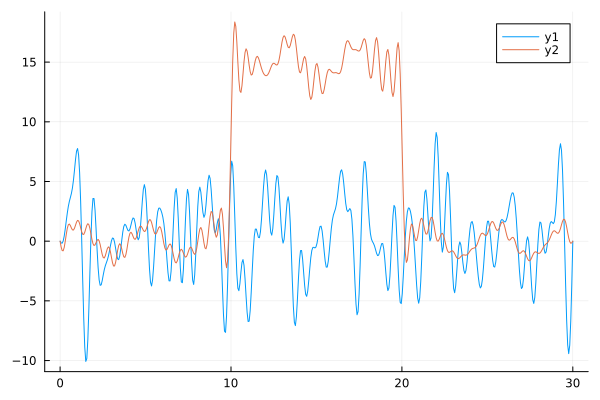

In [204]:
times = LinRange(0,30.0,500)

plot(times,[[pulse(p_new,t) for t in times],
            [pulse(p,t) for t in times]])

In [134]:
res

 * Status: success

 * Candidate solution
    Final objective value:     2.581933e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.15e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.94e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.13e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.39e-05 ≤ 5.0e-05
    |g(x)|                 = 6.30e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   275896  (vs limit Inf)
    Iterations:    110
    f(x) calls:    259
    ∇f(x) calls:   259


In [168]:
forward_prob = ODEProblem(H_int!, ψ1s, (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-12, abstol=1e-15)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [5.418078904180145e-11 - 7.438731478986858e-10im -9.632877412248809e-11 + 7.100334808286369e-10im; -2.0595477340515898e-9 - 4.912765290019867e-9im -3.0309675269661524e-9 + 4.176362259251368e-9im; … ; 2.7496870238307195e-9 - 4.562479714918854e-9im 1.8086932324195138e-9 + 4.832948921668281e-9im; 5.418077315847918e-11 - 7.438731105162084e-10im -9.632873904786962e-11 + 7.100334915262475e-10im]
 [4.890721659329067e-10 + 5.621017200142815e-10im -4.611842444144883e-10 - 5.477373304061067e-10im; 4.9318785831941

In [199]:
occs[end,:,:]

2×2 Matrix{Float64}:
 0.906508     0.000525715
 0.000114041  0.904611

In [169]:
# tmp'*ψ1s[:,2]
# sol_new.u[end,1,:]

In [170]:
tmp = sol_new.u[end][:,1]
2*real(-im * tmp'*ψ1s[:,2]*ψ1s[:,2]'* (Kinetic + Potential3) * tmp)

0.019098861226347325

In [171]:
occs = zeros(Float64,1000,2,2)
# tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    # tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψ1s'*sol_new.u[i])
end

In [172]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [173]:
# The optimized run:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 2.906667984678622
# 12.109931540601726
# 10.0
# 0.5
# -18.04217394300753
# 6.786309632141689
# 1.83211636655623
# 3.1258846903218442
# -0.05818774908497257

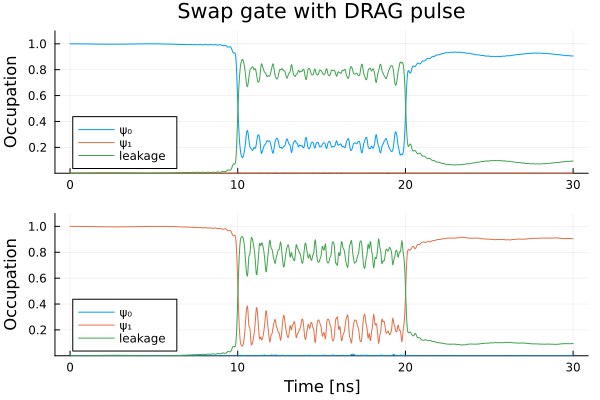

In [174]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     # yaxis=:log,
     ylims=(1e-10,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "leakage"],
     ylabel="Occupation")

In [202]:
# 
UT = occs[end,:,:]
# 0.5 * (2 - UT[1,2] - UT[2,1])
UT

2×2 Matrix{Float64}:
 0.906508     0.000525715
 0.000114041  0.904611

In [143]:
# savefig(outputplot,"Figures/SwapOptFourierPulse100p.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptFourierPulse100p.pdf"

In [48]:
tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=10, which=:SR)
(abs2.(tmpψs'*sol_new.u[end]))

10×2 Matrix{Float64}:
 3.41985e-9  0.999945
 0.999947    6.20638e-9
 6.14343e-6  1.84828e-5
 9.55816e-6  2.05383e-6
 1.20276e-5  1.96376e-5
 2.30988e-5  1.33064e-5
 3.96923e-7  7.68583e-7
 1.16722e-6  1.05994e-7
 1.76384e-7  1.4717e-7
 3.33207e-7  3.01871e-7